In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# from tqdm.notebook import tqdm
from tqdm import tqdm
import pickle
from functions import (
    SimulateRateFull,
    SolverRateManager,
    get_eq_times,
)
from functions import forces_dict_2
from functions import simulate_traj_g
from setup import setup_matplotlib

setup_matplotlib()

np.random.seed(42)

In [3]:
version = 2

k = 1
border = 0
x_0 = -1
N_x_border = 12.5
max_t = 10
ntau = 2
force = "cusp_force"


dx = (border - x_0) / N_x_border
sb = 40.5 * dx  # with .5, 0 not included

f = 15
N_p = 2_000
N_loop = 10
eq_perc = 0.75
eq_f = 0.75
ntau_sim = ntau * f


x_s = np.arange(-sb, sb + 1e-6, dx)
i_zero = np.argmin((x_s - x_0) ** 2)
N_x = len(x_s)

s_s = np.arange(0.2, 0.81, 0.1)
# s_s = np.array([0.3])
# ltaus = np.array([0.1])
ltaus = np.concatenate(([0, 0.05], np.arange(0.2, np.pi / 2, 0.2)))

sim_rate = np.empty((len(s_s), len(ltaus), 4), float)
num_rate = np.empty((len(s_s), len(ltaus), 4), float)

In [4]:
my_rate_manager = SimulateRateFull()

for j, s in enumerate(tqdm(s_s)):
    D = s**2 / 2

    for i, ltau in enumerate(tqdm(ltaus)):
        ldt = ltau / ntau_sim if ltau > 0 else ltaus[1] / ntau_sim
        q_f = np.log(1 - eq_f) / np.log(1 - eq_perc)
        rel_time = q_f * get_eq_times(ltau, D, eq_perc, a=0, b=1)
        N_t = max(int(2 * rel_time / ldt), int(max_t / ldt), 30)

        sim_ts = (
            np.arange(-ntau_sim, N_t) * ldt if ltau > 0 else np.arange(0, N_t) * ldt
        )

        res = my_rate_manager.run(
            N_p=N_p,
            N_loop=N_loop,
            N_t=N_t,
            ntau=ntau_sim if ltau > 0 else 0,
            s=s,
            dt=ldt,
            x_0=x_0,
            force=force,
            border=border,
        )
        sim_sur = res["sim_sur"]

        sim_cond = (sim_ts > rel_time) * (sim_sur - 1 / 2 > 0.05)
        sim_rates = [
            -np.mean(np.diff(np.log(2 * sim_sur[i, this_sim_cond] - 1)) / ldt)
            for i, this_sim_cond in enumerate(sim_cond)
        ]

        mean_sim_rates = np.mean(sim_rates, axis=0)
        sim_rate[j, i] = (
            np.mean(sim_rates),
            np.std(sim_rates) / np.sqrt(N_loop),
            np.min(mean_sim_rates),
            np.max(mean_sim_rates),
        )

100%|██████████| 9/9 [00:00<00:00, 278.96it/s]


 43%|████▎     | 3/7 [00:00<00:00, 25.18it/s]/home/nils/anaconda3/envs/kroy/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nils/anaconda3/envs/kroy/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 7/7 [00:32<00:00,  4.68s/it]


In [5]:
my_solver_rate_manager = SolverRateManager()

for j, s in enumerate(tqdm(s_s)):
    D = s**2 / 2

    for i, ltau in enumerate(tqdm(ltaus)):
        ldt = ltau / ntau if ltau > 0 else ltaus[1] / ntau
        q_f = np.log(1 - eq_f) / np.log(1 - eq_perc)
        rel_time = q_f * get_eq_times(ltau, D, eq_perc, a=0, b=1)
        N_t = max(int(2 * rel_time / ldt), int(max_t / ldt), 30)

        ts = np.arange(0, N_t) * ldt

        # N_t, N_x, sbs, ntau, s, dt, x_0, force, version

        res = my_solver_rate_manager.run(
            N_t=N_t,
            N_x = N_x,
            sbs = [-sb, sb],
            ntau=ntau if ltau > 0 else 0,
            s=s,
            dt=ldt,
            x_0=x_0,
            force=force,
            border = border,
            version = version,
        )
        num_sur = res["num_sur"]

        num_cond = (ts > rel_time) * (num_sur - 1 / 2 > 0.05)
        num_rates = -np.mean(np.diff(np.log(2 * num_sur[num_cond] - 1)) / ldt)
        num_rate[j, i] = (
            np.mean(num_rates),
            0,
            np.min(num_rates),
            np.max(num_rates),
        )

100%|██████████| 9/9 [00:00<00:00, 312.52it/s]


100%|██████████| 7/7 [01:50<00:00, 15.72s/it]


# Visualtisation

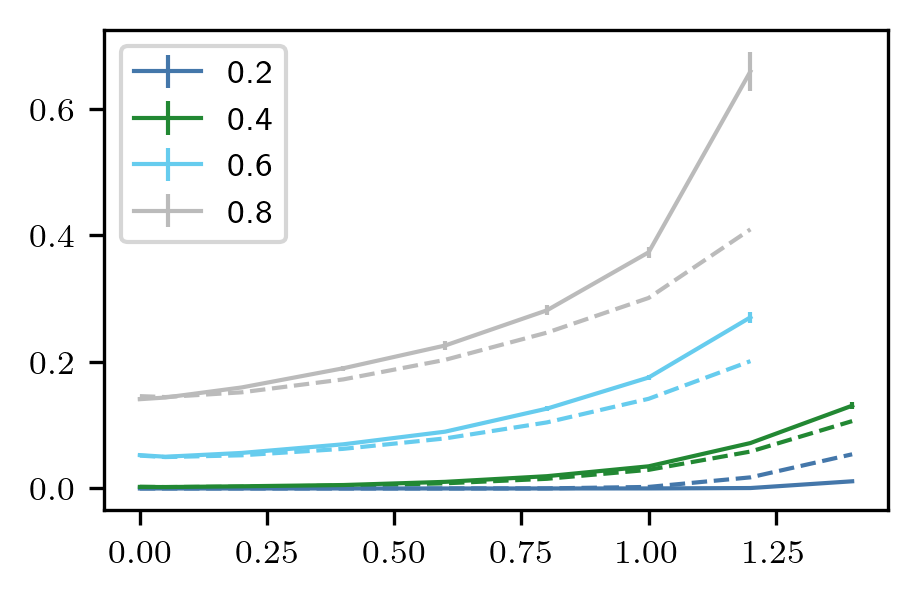

In [6]:
for i in range(0, len(s_s), 2):
    plt.errorbar(ltaus, sim_rate[i, :, 0], sim_rate[i, :, 1], color = f'C{i}', label=round(s_s[i], 2))
    plt.plot(ltaus, num_rate[i, :, 0], ls = '--',  color = f'C{i}')
plt.legend()
#plt.yscale('log')

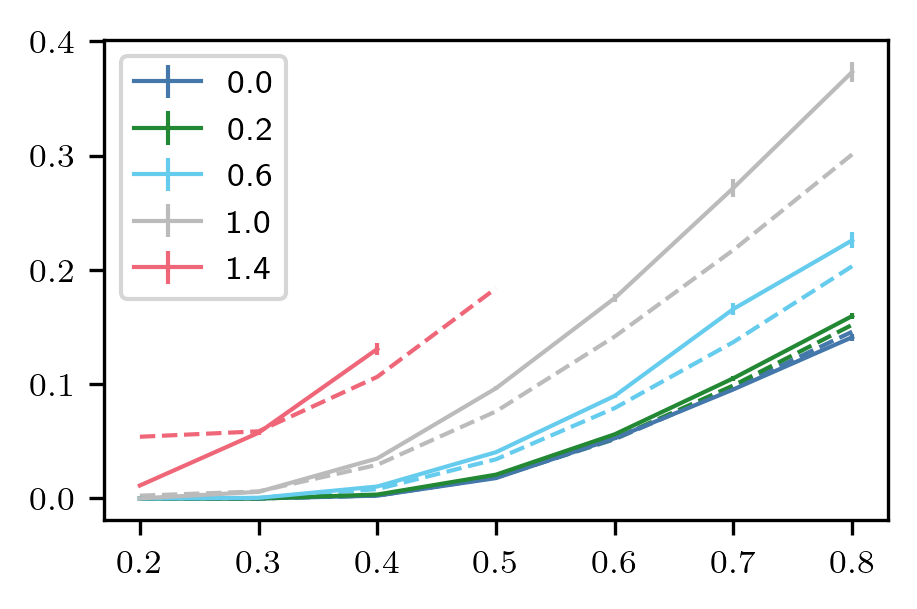

In [7]:
for i in range(0,len(ltaus),2):
    plt.errorbar(s_s, sim_rate[:, i, 0], sim_rate[:, i, 1], color = f'C{i}', label=round(ltaus[i], 2))
    plt.plot(s_s, num_rate[:, i, 0], ls = '--',  color = f'C{i}')
plt.legend()
#plt.yscale('log')
#plt.ylim(1e-3, 1e0)

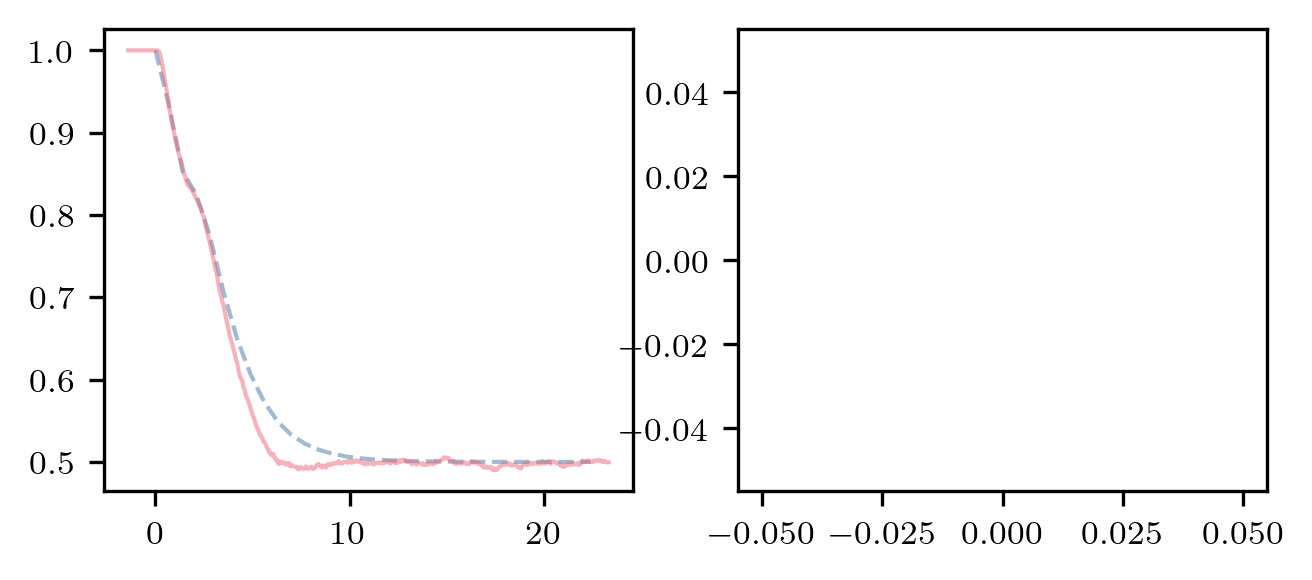

In [8]:
idx = 3
tsim_sur = np.mean(sim_sur, axis=0)
plt.figure(figsize=(5, 2))
plt.subplot(121)
plt.plot(ts, num_sur, color="C0", ls="--", alpha=0.5)
plt.plot(ts[num_cond], num_sur[num_cond], color="C0", ls="--")

plt.plot(sim_ts, tsim_sur, color="C1", alpha=0.5)

# plt.plot(sim_ts,sim_sur[idx], color = 'C1', alpha= .5)
# plt.plot(sim_ts[sim_cond[idx]],sim_sur[idx][sim_cond[idx]], color = 'C1')
plt.ylim(*plt.ylim())
plt.subplot(122)
# plt.plot(ts[1:],np.diff(np.log(2*num_sur-1))/ldt, color = 'C0', ls = '--', alpha =.5)
plt.plot(
    ts[num_cond][1:],
    -np.diff(np.log(2 * num_sur[num_cond] - 1)) / ldt,
    color="C0",
    ls="--",
)
# plt.plot(sim_ts[1:],np.diff(np.log(2*sim_sur[idx]-1))/ldt*f, color = 'C1', alpha= .5)
plt.plot(
    sim_ts[sim_cond[idx]][1:],
    -np.diff(np.log(2 * sim_sur[idx][sim_cond[idx]] - 1)) / ldt * f,
    color="C1",
)

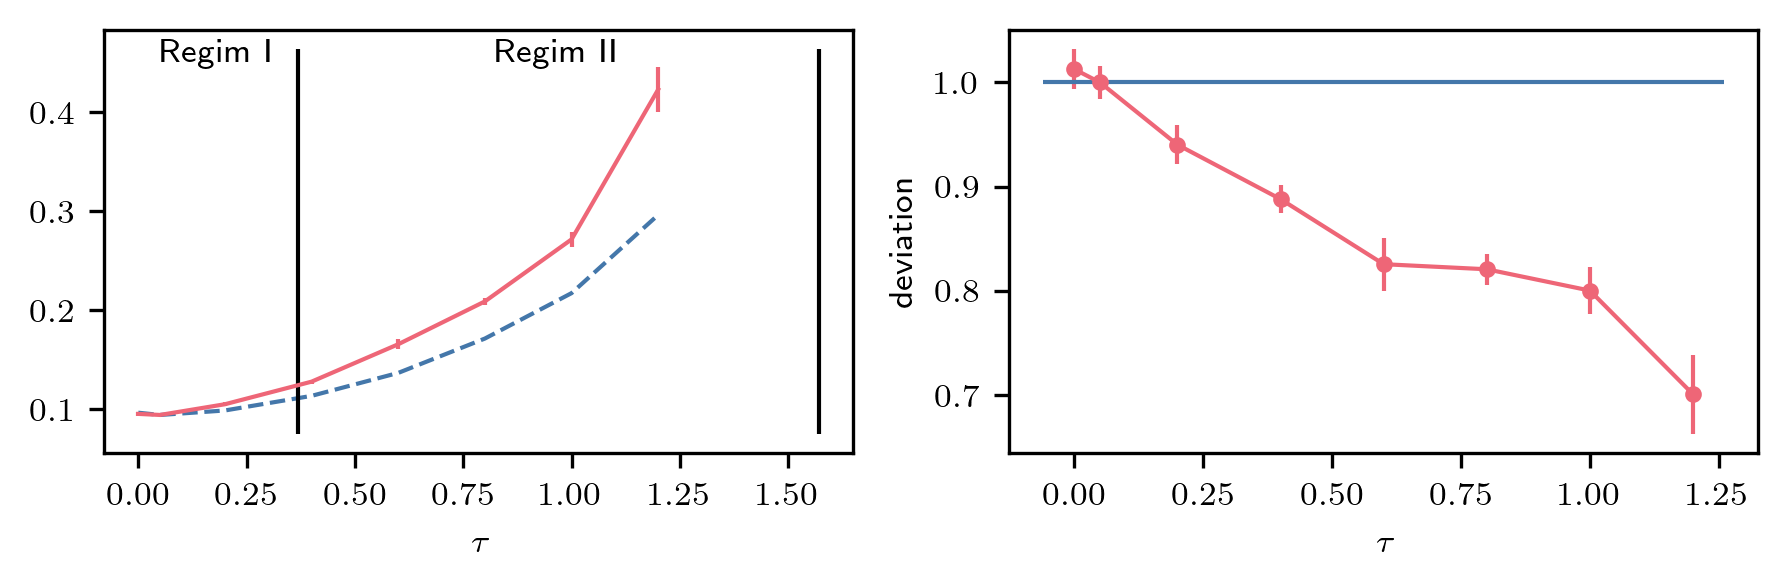

In [9]:
idx = 5

plt.figure(figsize=(6, 2))
plt.subplot(121)
plt.plot(ltaus, num_rate[idx,:, 0], "--")
plt.errorbar(ltaus, sim_rate[idx,:, 0], sim_rate[idx,:, 1])


# plt.xlim(0,2.1)
# plt.ylim(1e-3,1)

plt.vlines([1 / np.e / k, np.pi / 2 / k], *plt.ylim(), color="black")

y = 0.95*plt.ylim()[1]
plt.text(0.5 * 1 / np.e / k, y, "Regim I", ha="center", va="center")
plt.text(0.5 * (1 / np.e / k + np.pi / 2 / k), y, "Regim II", ha="center", va="center")
# plt.text(
#     0.5 * (np.pi / 2 / k + plt.xlim()[1]), y, "Regim III", ha="center", va="center"
# )
plt.xlabel(r"$\tau$")
# plt.ylabel('1/rate')
# plt.yscale('log')

plt.subplot(122)

# plt.plot(ltaus, num_rate[idx,:, 0] / sim_rate[idx,:, 0])
plt.errorbar(
    ltaus,
    num_rate[idx, :, 0] / sim_rate[idx, :, 0],
    yerr=np.sqrt(
        (num_rate[idx, :, 1] / sim_rate[idx, :, 0]) ** 2
        + (num_rate[idx, :, 0] / sim_rate[idx, :, 0] ** 2 * sim_rate[idx, :, 1]) ** 2
    ),
    marker=".",
    color="C1",
)
plt.hlines(1,*plt.xlim())
plt.xlabel(r"$\tau$")
plt.ylabel("deviation")
plt.tight_layout()
# plt.savefig(f'graphics/cusp_rates_s{s}.pdf')